In [9]:
import src
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from warnings import filterwarnings
# Pandas will give a lot of warning while I am mutating data frames in functions.
filterwarnings('ignore')
# Matplot lib inline
plt.style.use('seaborn')
%matplotlib inline

# Initial Questions Relating to Budget and ROI
We were interested in whether there is a diminishing return on investment for movie budgets. Is there a goldilocks zone for movie budgets where Microsoft should focus their efforts? Lets dive into the cleaned budget dataframe and check it out!

In [10]:
df = pd.read_csv("rawdata/clean_roi_budget_data")
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,domestic_profit,has foriegn,roi,domestic_roi,lost_money,outlier_budget,budget_category
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2009,2.351345e+09,335507625.0,True,553.257713,78.942971,False,True,large
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,6.350639e+08,-169536125.0,True,154.667286,-41.289850,False,True,large
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,-2.002376e+08,-307237650.0,True,-57.210757,-87.782186,True,True,large
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,1.072414e+09,128405868.0,True,324.384139,38.840250,False,True,large
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,9.997217e+08,303181382.0,True,315.369636,95.640815,False,True,large


# Early Exploration
The first plot we will look at is a simple scatter plot with budget on the x axis and ROI on the y axis. We used budget category as our 'hue' to visually illustrate the difference between the different budget categories. Budget categories were added as part of the data cleaning process. The small budget category is movies that cost less than 5 million usd to make, the medium category is movies that cost between 5 million usd and 100 million and the large budget category is movies that cost over 100 million. These categories were roughly based on [industry](https://stephenfollows.com/average-budget-low-micro-budget-film/)  [standards](https://industrialscripts.com/great-mid-budget-movies/), althouth there is no exact number for what makes a movie "small budget."

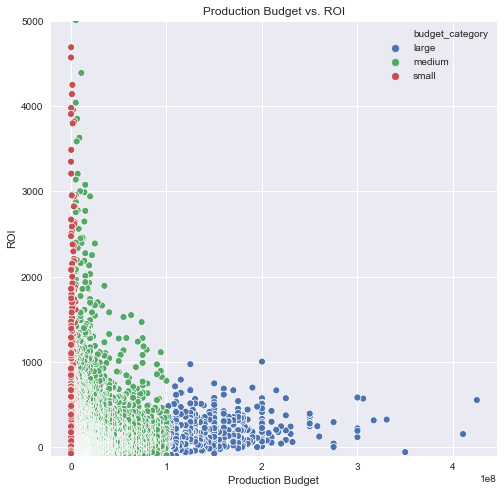

In [59]:
fig2, axes = plt.subplots( figsize = (8,8))
ax = sns.scatterplot(x = 'production_budget', y = 'roi',hue = 'budget_category', data = df)
ax.set(ylim = (-100,5000))
ax.set_title('Production Budget vs. ROI')
ax.set_ylabel('ROI')
ax.set_xlabel('Production Budget')
plt.savefig( 'Production Budget vs. ROI.png')

Wow! if anything budget size seems to have a negative correlation with ROI. However there are also massive outliers in the small category with ROIs over 1000%. Lets Plot the data without these small budget movies that garnered absurd ROIs and see what the data looks like.

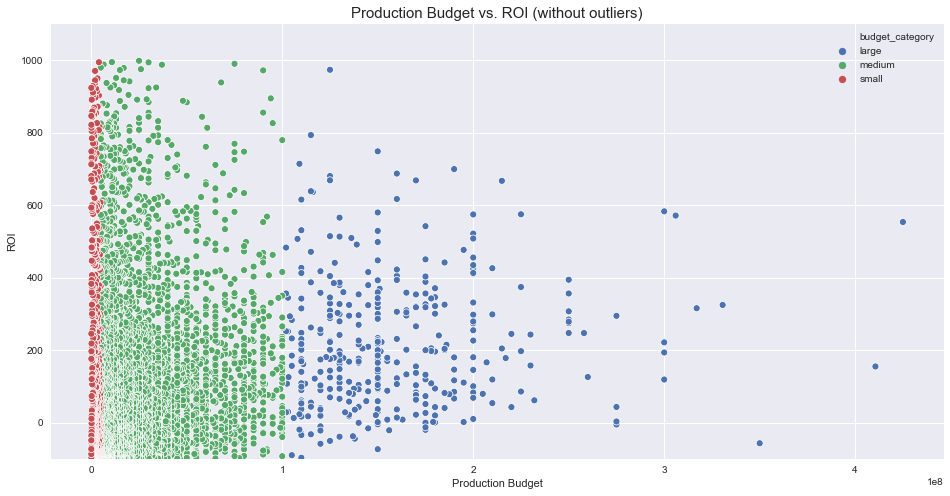

In [62]:
df2 = df[df.roi<1000]
fig2, axes = plt.subplots( figsize = (16, 8))
ax = sns.scatterplot(x = 'production_budget', y = 'roi',hue = 'budget_category', data = df2)
ax.set(ylim = (-100,1100))
ax.set_title('Production Budget vs. ROI (without outliers)', size = 15)
ax.set_ylabel('ROI')
ax.set_xlabel('Production Budget')
plt.savefig( 'Production Budget vs. ROI.png')

Ok now it still looks like small and medium budget movies produce a higher but more variable roi, while the majoiry of high budget movies are clustered in a similar place to small and medium budget movies. Its also interesting that large budget movies seem to have less points with a negative ROI. **This led us to a further question: which budget category carries the most risk?**

# Average ROI

The following bar graphs look at the average roi for each budget category. 

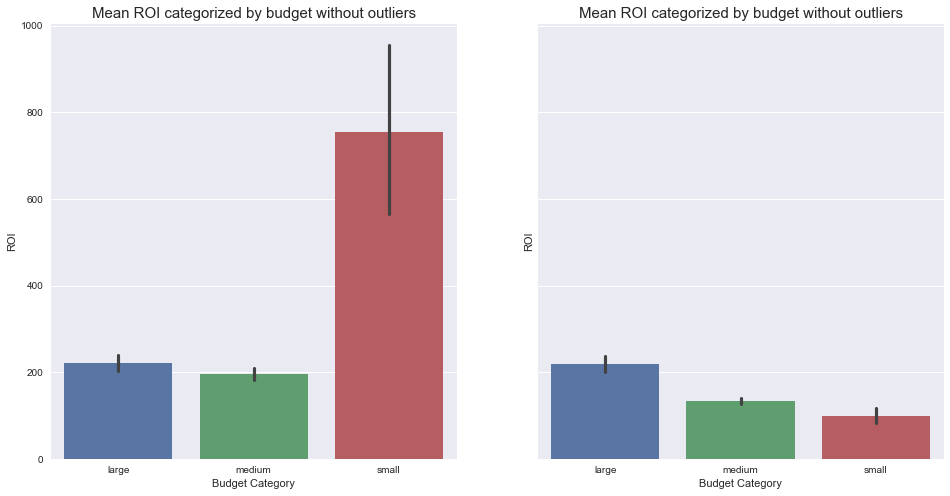

In [61]:

fig, axes = plt.subplots(1, 2, figsize = (16,8), sharey = True)
sns.barplot(y= df['roi'], x = df['budget_category'], ax = axes[0]);
axes[0].set_title('Mean ROI categorized by budget without outliers', size = 15)
axes[0].set_ylabel('ROI')
axes[0].set_xlabel('Budget Category');
axes[1] = sns.barplot(y= df[df['roi']<1000]['roi'], x = df['budget_category'], ax = axes[1]);
plt.title('Mean ROI categorized by budget without outliers', size = 15)
plt.ylabel('ROI')
plt.xlabel('Budget Category');

With the outliers, small moves crush average ROI. Interestingly large and medium budget movies do about the same. With or without the outliers, but small movies do much worse. Unless your small movie is an absolute run away success you can do the best by focusing on large budget movies.

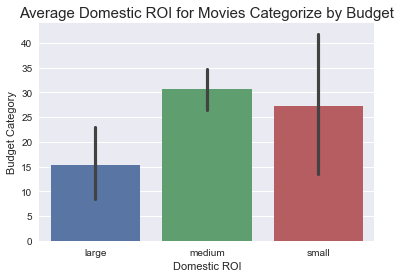

In [64]:
y =df['domestic_roi']
sns.barplot(y= y, x = df[df.roi<1000]['budget_category']);
plt.title('Average Domestic ROI for Movies Categorize by Budget', size = 15)
plt.xlabel('Domestic ROI')
plt.ylabel('Budget Category');

With just domestic ROI no budget category is even close to the ROI it garners from worldwide distribution. We strongly recommend that Microsoft distribute their content globally, almost as a neccesity.

In [19]:
#Calculating the percent chance that a project lost money for each category

p_lost_money_small = len(df[(df.budget_category == 'small') & (df.lost_money == True)])/len(df[df.budget_category =='small']) * 100

p_lost_money_medium = len(df[(df.budget_category == 'medium') & (df.lost_money == True)])/len(df[df.budget_category =='medium']) * 100

p_lost_money_large = len(df[(df.budget_category == 'large') & (df.lost_money == True)])/len(df[df.budget_category =='large']) * 100

x = ['Small Budget', 'Medium Budget', 'Large Budget']
y = [p_lost_money_small, p_lost_money_medium, p_lost_money_large]

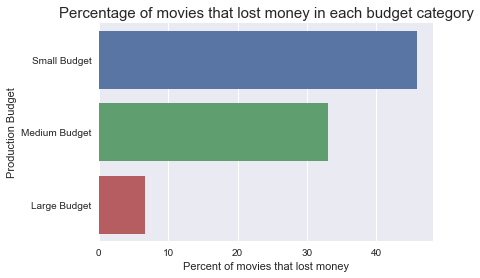

In [29]:
ax = sns.barplot(y, x);
ax.set_title('Percentage of movies that lost money in each budget category', size = 15)
plt.xlabel('Percent of movies that lost money')
plt.ylabel('Production Budget');

Its clear that as budget increases, the risk of losing money on your project goes down. That being said the more expensive a project the more money its possible to lose. Small budget may have the possibility of massive ROI, but they are also clearly the most risky.

# Conclusion on Budget ROI section

We Recommend that Microsoft use most of their money on large budget movies which offer less risk and a predictable ROI. Medium budget movies are high risk and do not have much upside, they should be avoided. Small budget movies offer the possibility of ROIs over 1000% but are extremely risky. Small budget movies should not be the foundation of Microsofts content but they also shouldnt shy away from them in the hope that one goes 'viral.' Next we will look ahead at what genre Microsoft should focus on for their large productions, and if certain small budget movies have a higher chance of producing massive ROIs.

In [154]:
# import the cleaned data as described in /datacleaning/genrecleaning.ipynb
df1  = pd.read_csv('rawdata/genres-budget.csv')
df_titles = pd.read_csv('rawdata/title.csv')

In [155]:
df1.head()

,tconst,genres,numvotes,averagerating,start_year,runtime_minutes,Adult,Sport,Sci-Fi,Fantasy,...,Comedy,Action,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,roi
0,tt0249516,"Action,Animation,Comedy",8248,1.9,2012,91.0,False,False,False,False,...,True,True,2012-12-31,foodfight!,45000000.0,$0,73706.0,2012,12,-99.836209
1,tt0337692,"Adventure,Drama,Romance",37886,6.1,2012,124.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
2,tt4339118,Drama,6,6.0,2014,89.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
3,tt5647250,Drama,127,5.7,2016,121.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
4,tt0359950,"Adventure,Comedy,Drama",275300,7.3,2013,114.0,False,False,False,False,...,True,False,2013-12-25,the secret life of walter mitty,91000000.0,"$58,236,838",187861183.0,2013,12,106.440860


### Explanation of the table
We wrangled this data from data sets scraped from imdb and  includes a truth matrix for all the genres to allow simple indexing as well as metadata pertaining the movies overall success.

We removed all observations with missing values for genre, worldwide_gross and production_budget as these values are critical to our hyptotheses. In addition, no observations from before 2010 and after 2019 were included in the data set. This was to insure the relevance of the data to the business question at hand.

### Genre Analysis
Our first hypothesis was that genre played a large role in the ratings and success of a movie. To test this we created a custom function to examine the average return on investment (roi) and total international gross revenue.

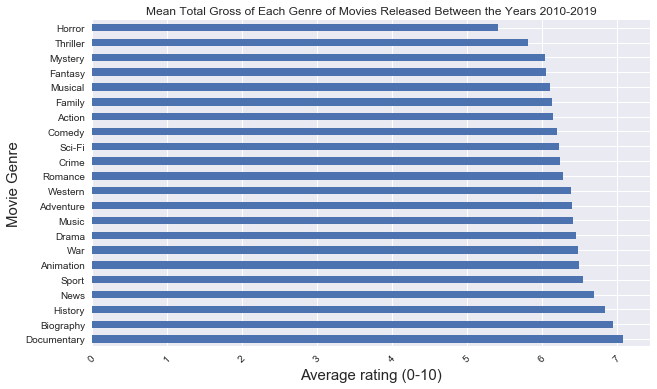

In [156]:
# src function and documentation available in src.py
df1.genres = src.coerce_to_list(df1, 'genres')
df_to_plot = src.genre_pandas_mean(df1, 'averagerating')
df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Mean Total Gross of Each Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('Average rating (0-10)', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

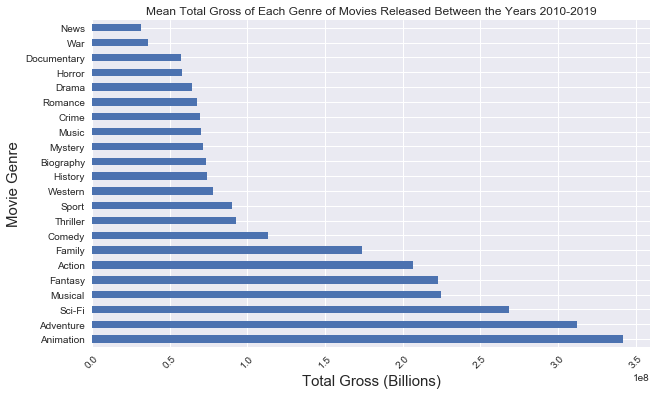

In [157]:
df_to_plot = src.genre_pandas_mean(df1, 'worldwide_gross')
df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Mean Total Gross of Each Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('Total Gross (Billions)', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

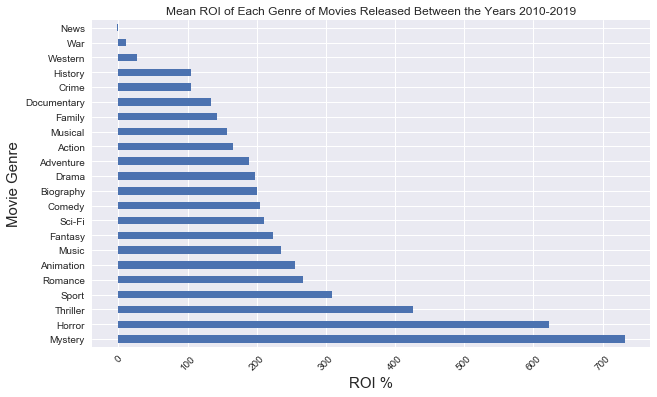

In [158]:
# See src.genre_pandas_mean in src documentation
df_to_plot = src.genre_pandas_mean(df1, 'roi')
df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Mean ROI of Each Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

From the preliminary Anlysis, it seems like though animated movies as a whole do really well, when it comes to return on investment, there is none better than mystery, horros and thrillers.

This begs the question, is there some magical combination of genres that leads to high return on investment?

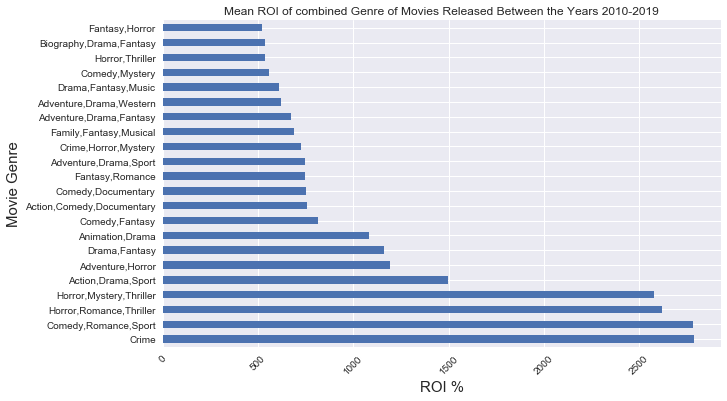

In [159]:
# Reload the database to reset the genre column from list back to string
df1 = pd.read_csv('rawdata/genres-budget.csv')

# Group the values by genre (combinations present this time) and check ROI for the top 22 genres
grouped = df1.groupby(['genres']).roi.mean().sort_values(ascending=False)[:22]

# Create chart based on the data
# See src.genre_pandas_mean in src documentation
grouped.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Mean ROI of combined Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

#### So as it happens, crime does pay!

Or atleast people are willing to spend a signeficant amount of money to watch it. 

What is the highest ROI crime movie of all time?

In [143]:
highest_crime = df1.sort_values('roi', ascending = False)[df1.Crime == True].iloc[0,:1].values[0]
df_titles[df_titles.tconst == highest_crime]

,primary_title,tconst
1734,split,tt3604256


More of a mystery/crime/thriller if you ask us but interesting none the less. 

The trend is that horror movies, thrillers and crime movies generate a great return on investment. But, does is matter how much money you invest initially? It there a point of dimninishing returns for your investment?